### Overlap中求解完全子图

#### ALL的不分类别的完全子图求解

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as path_effects
import seaborn as sns
from pathlib import Path
import colorsys
import warnings
import networkx as nx
import matplotlib.patches as mpatches
import random
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")

# ==========================================
# 配置与路径
# ==========================================
CURRENT_DIR = Path.cwd()
DATA_DIR = CURRENT_DIR.parent / "data"
OUTPUT_DIR = DATA_DIR / "4-1-2-clique_analysis"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_FILES = [
    DATA_DIR / "4-1-overlapping_cluster_heatmap_Breadth.csv",
    DATA_DIR / "4-1-overlapping_cluster_heatmap_Intensity.csv"
]

def get_font():
    return FontProperties(family="Times New Roman", size=26, weight="black")

T_FONT = get_font()

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "black",
    "axes.labelweight": "black",
    "axes.titleweight": "black",
    "axes.unicode_minus": False,
    "figure.dpi": 300
})
sns.set_theme(style="white")

def get_palette(k):
    base_colors = [
        '#E63946', '#1D3557', '#457B9D', '#A8DADC', '#2A9D8F', 
        '#F4A261', '#E76F51', '#264653', '#8AB17D', '#B5838D',
        '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173'
    ]
    if k <= len(base_colors):
        return base_colors[:k]
    return (base_colors * (k // len(base_colors) + 1))[:k]

def lighten_color_slightly(hex_color: str) -> str:
    r, g, b = plt.cm.colors.to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return plt.cm.colors.to_hex(colorsys.hls_to_rgb(h, min(1.0, l + 0.12), s * 0.88))

# ==========================================
# 数据处理
# ==========================================
def read_matrix(path):
    df = pd.read_csv(path, index_col=0, encoding="utf-8-sig")
    df.index = df.index.astype(str).str.strip()
    df.columns = df.columns.astype(str).str.strip()
    common = [c for c in df.columns if c in df.index]
    df = df.loc[common, common]
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    df = (df + df.T) / 2.0
    return df.round(0).astype(int)

def build_graph(df, k=None):
    countries = df.index.tolist()
    G = nx.Graph()
    G.add_nodes_from(countries)
    
    if k is None:
        rows, cols = np.where(df.values > 0)
    else:
        rows, cols = np.where(df.values >= k)
        
    for r, c in zip(rows, cols):
        if r < c:
            G.add_edge(countries[r], countries[c], weight=df.iloc[r, c])
    return G

def get_metrics(df, members):
    n = len(members)
    if n < 2: return n, 0.0, 0.0
    vals = df.loc[members, members].values[np.triu_indices(n, k=1)]
    return n, float(np.sum(vals)), float(np.var(vals)) if len(vals) > 0 else 0.0

# ==========================================
# 算法逻辑
# ==========================================
def find_disjoint_order(df, k):
    G = build_graph(df, k)
    ordered = []
    while G.number_of_nodes() > 0:
        cliques = list(nx.find_cliques(G))
        cands = [c for c in cliques if len(c) >= 3]
        
        if not cands:
            rem = sorted(G.nodes(), key=lambda n: G.degree[n], reverse=True)
            ordered.extend(rem)
            break
            
        objs = []
        for c in cands:
            s, w, v = get_metrics(df, c)
            objs.append((c, s, w, v))
        
        random.shuffle(objs)
        objs.sort(key=lambda x: (-x[1], -x[2], x[3]))
        
        best = objs[0][0]
        if len(best) > 1:
            local_w = df.loc[best, best].sum(axis=1).sort_values(ascending=False)
            ordered.extend(local_w.index.tolist())
        else:
            ordered.extend(best)
        G.remove_nodes_from(best)
        
    rest = list(set(df.index) - set(ordered))
    if rest:
        w = df.loc[rest, rest].sum(axis=1).sort_values(ascending=False)
        ordered.extend(w.index.tolist())
    return ordered

def find_overlapping_cliques(df, k):
    G = build_graph(df, k)
    cliques = list(nx.find_cliques(G))
    cands = [c for c in cliques if len(c) >= 3]
    if not cands: return pd.DataFrame()

    objs = []
    for c in cands:
        s, w, v = get_metrics(df, c)
        objs.append({"m": c, "s": s, "w": w, "v": v})
    
    random.shuffle(objs)
    objs.sort(key=lambda x: (-x["s"], -x["w"], x["v"]))
    
    accepted = []
    visited_union = set()
    
    for obj in objs:
        nodes = set(obj["m"])
        if len(nodes - visited_union) == 0: continue
        
        accepted.append({
            "members": ",".join(sorted(list(nodes))),
            "size": obj["s"], "sum_weight": obj["w"]
        })
        visited_union.update(nodes)
        
    res = pd.DataFrame(accepted)
    if not res.empty:
        res["ID"] = range(1, len(res) + 1)
    return res

# ==========================================
# 绘图函数
# ==========================================
def draw_heatmap(df, order, max_val, out_path):
    # 【恢复原始热力图样式】
    if not order or df.empty: return
    df_plot = df.loc[order, order]
    size = max(18, df.shape[0] * 0.72)
    
    g = sns.clustermap(
        df_plot, row_cluster=False, col_cluster=False, cmap="RdYlBu_r",
        figsize=(size, size), annot=True, fmt="d", vmin=0, vmax=max_val,
        annot_kws={"fontsize": 28, "weight": "black", "fontproperties": T_FONT},
        cbar_kws={"ticks": [0, int(max_val*0.25), int(max_val*0.5), int(max_val*0.75), max_val]},
        tree_kws={"linewidths": 0}, dendrogram_ratio=0.01, linewidths=0.5
    )
    
    # 样式完全复原
    hm_pos = g.ax_heatmap.get_position()
    pad = 0.04; cbar_w = 0.018; cbar_h = hm_pos.height * 0.78
    cbar_y = hm_pos.y0 + hm_pos.height * 0.11
    g.cax.set_position([hm_pos.x1 + pad, cbar_y, cbar_w, cbar_h])
    g.cax.yaxis.set_label_position("right")
    g.cax.set_axisbelow(False)
    g.cax.tick_params(axis="y", direction="in", length=12, width=3, colors="black", right=True, pad=6)
    g.cax.set_ylabel(f"Overlap Count", fontproperties=T_FONT, fontsize=32, weight="black", labelpad=20)
    plt.setp(g.cax.get_yticklabels(), fontproperties=T_FONT, fontsize=28, weight="black")
    
    for lab in g.ax_heatmap.get_xticklabels():
        lab.set_fontproperties(T_FONT); lab.set_rotation(45); lab.set_ha("right")
    for lab in g.ax_heatmap.get_yticklabels():
        lab.set_fontproperties(T_FONT); lab.set_rotation(0)
        
    for spine in g.ax_heatmap.spines.values():
        spine.set_visible(True); spine.set_linewidth(4); spine.set_edgecolor("black")
    g.ax_heatmap.set_title("")
    
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close("all")

def draw_network(df, df_res, G_vis, out_path, title):
    if df_res.empty: return
    palette = get_palette(len(df_res))
    
    # 1. 建立归属关系
    edge_map = {}
    node_map = {}
    clique_edges = []
    
    for _, row in df_res.iloc[::-1].iterrows():
        cid = row["ID"]
        col = palette[(cid - 1) % len(palette)]
        mems = row["members"].split(",")
        
        for m in mems:
            if m not in node_map: node_map[m] = set()
            node_map[m].add(cid)
            
        for i in range(len(mems)):
            for j in range(i+1, len(mems)):
                u, v = mems[i], mems[j]
                clique_edges.append((u, v))
                if G_vis.has_edge(u, v):
                    edge_map[tuple(sorted((u, v)))] = col

    # 2. 布局逻辑 (分离策略)
    countries = df.index.tolist()
    G_layout = nx.Graph()
    G_layout.add_nodes_from(countries)
    
    # (A) 团内核心边：极高引力，强制抱团
    for u, v in clique_edges:
        G_layout.add_edge(u, v, weight=50.0) 
        
    # (B) 背景弱边：极低引力，只保持微弱联系
    # 这样非团节点会松散地聚在一起，而团与团之间会分开
    rows, cols = np.where(df.values > 0)
    for r, c in zip(rows, cols):
        if r < c:
            u, v = countries[r], countries[c]
            if not G_layout.has_edge(u, v): 
                # 这里给非常小的权重，让它们可以被拉开
                G_layout.add_edge(u, v, weight=0.01) 
            
    # k值调大 (1.2) 以撑开整体布局，防止糅杂
    pos = nx.spring_layout(G_layout, k=1.2, weight='weight', iterations=200, seed=42)

    fig, ax = plt.subplots(figsize=(40, 40)) 
    
    # 3. 绘图元素
    fg_edges, fg_colors, fg_widths = [], [], []
    bg_edges = []
    
    for u, v, d in G_vis.edges(data=True):
        key = tuple(sorted((u, v)))
        w = d.get('weight', 1)
        if key in edge_map:
            fg_edges.append((u, v))
            fg_colors.append(edge_map[key])
            fg_widths.append(3.5 + np.log1p(w)*0.5)
        else:
            bg_edges.append((u, v))

    clique_nodes = [n for n in G_vis.nodes() if n in node_map]
    bg_nodes = [n for n in G_vis.nodes() if n not in node_map]
    
    clique_cols = []
    for n in clique_nodes:
        best = min(node_map[n])
        clique_cols.append(palette[(best-1) % len(palette)])

    # (1) 背景边：透明度调高至 0.6
    if bg_edges:
        nx.draw_networkx_edges(G_vis, pos, edgelist=bg_edges, width=1.5, 
                               edge_color="#BBBBBB", alpha=0.6, ax=ax)
    
    # (2) 背景点：透明度调高至 0.6，大小调大至 600
    if bg_nodes:
        nx.draw_networkx_nodes(G_vis, pos, nodelist=bg_nodes, 
                               node_color="#D0D0D0", node_size=600, 
                               edgecolors='#AAAAAA', linewidths=1.5, alpha=0.6, ax=ax)

    # (3) 前景边
    if fg_edges:
        nx.draw_networkx_edges(G_vis, pos, edgelist=fg_edges, width=fg_widths, 
                               edge_color=fg_colors, alpha=0.95, ax=ax)
        
    # (4) 团节点：大小调大至 2200
    if clique_nodes:
        nx.draw_networkx_nodes(G_vis, pos, nodelist=clique_nodes, 
                               node_color=clique_cols, node_size=2200, 
                               edgecolors='white', linewidths=4.0, alpha=1.0, ax=ax)
        
    # (5) 标签
    if clique_nodes:
        lab_c = {n: n for n in clique_nodes}
        tc = nx.draw_networkx_labels(G_vis, pos, labels=lab_c, font_family="Times New Roman", 
                                     font_size=24, font_weight="bold", ax=ax)
        for t in tc.values():
            t.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])
            
    if bg_nodes:
        lab_b = {n: n for n in bg_nodes}
        tb = nx.draw_networkx_labels(G_vis, pos, labels=lab_b, font_family="Times New Roman", 
                                     font_size=16, font_color="#666666", ax=ax)

    # 图例
    patches = []
    for i, row in df_res.iterrows():
        if i >= 12: break
        c = palette[(row["ID"]-1)%len(palette)]
        patches.append(mpatches.Patch(color=c, label=f"C{row['ID']} (N={row['size']})"))
    patches.append(mpatches.Patch(color="#BBBBBB", label="Other Connections", alpha=0.6))
    
    plt.legend(handles=patches, prop={'family': 'Times New Roman', 'size': 26}, 
               frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(title, fontproperties=T_FONT, fontsize=50, pad=30)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

# ==========================================
# 主流程
# ==========================================
def process_file(path):
    print(f"Processing: {path.name}")
    df = read_matrix(path)
    if df.empty: return

    out_sub = OUTPUT_DIR / path.stem
    out_sub.mkdir(exist_ok=True)

    # 全局热力图
    w_sum = df.sum(axis=1).sort_values(ascending=False)
    draw_heatmap(df, w_sum.index.tolist(), int(df.values.max()), 
                 out_sub / f"Global_Heatmap.png")

    # 阈值循环
    name = "Intensity" if "Intensity" in path.name else "Breadth"
    k_range = range(12, 16) if name == "Intensity" else range(10, 16)

    def run_k(k):
        # 1. 团分析
        df_res = find_overlapping_cliques(df, k)
        if df_res.empty: return
        df_res.to_csv(out_sub / f"cliques_k{k}.csv", index=False)

        # 2. 结构化热力图
        order = find_disjoint_order(df, k)
        draw_heatmap(df, order, int(df.values.max()), 
                     out_sub / f"heatmap_struct_k{k}.png")

        # 3. 网络图
        G_vis = build_graph(df, k)
        draw_network(df, df_res, G_vis, out_sub / f"network_k{k}.png", f"{name} (K={k})")

    Parallel(n_jobs=-1)(delayed(run_k)(k) for k in k_range)

if __name__ == "__main__":
    for f in TARGET_FILES:
        if f.exists(): process_file(f)
        else: print(f"File not found: {f}")
    print("Done.")

Processing: 4-1-overlapping_cluster_heatmap_Breadth.csv
Processing: 4-1-overlapping_cluster_heatmap_Intensity.csv
Done.


#### 网络图单独画

Loading Policy Data...

Processing Breadth...
[Saved CSV] ../data/4-1-2-clique_analysis/4-1-overlapping_cluster_heatmap_Breadth/Network\Breadth_Structure_Analysis.csv
[Saved Image] ../data/4-1-2-clique_analysis/4-1-overlapping_cluster_heatmap_Breadth/Network\Breadth_Network_Graph.png


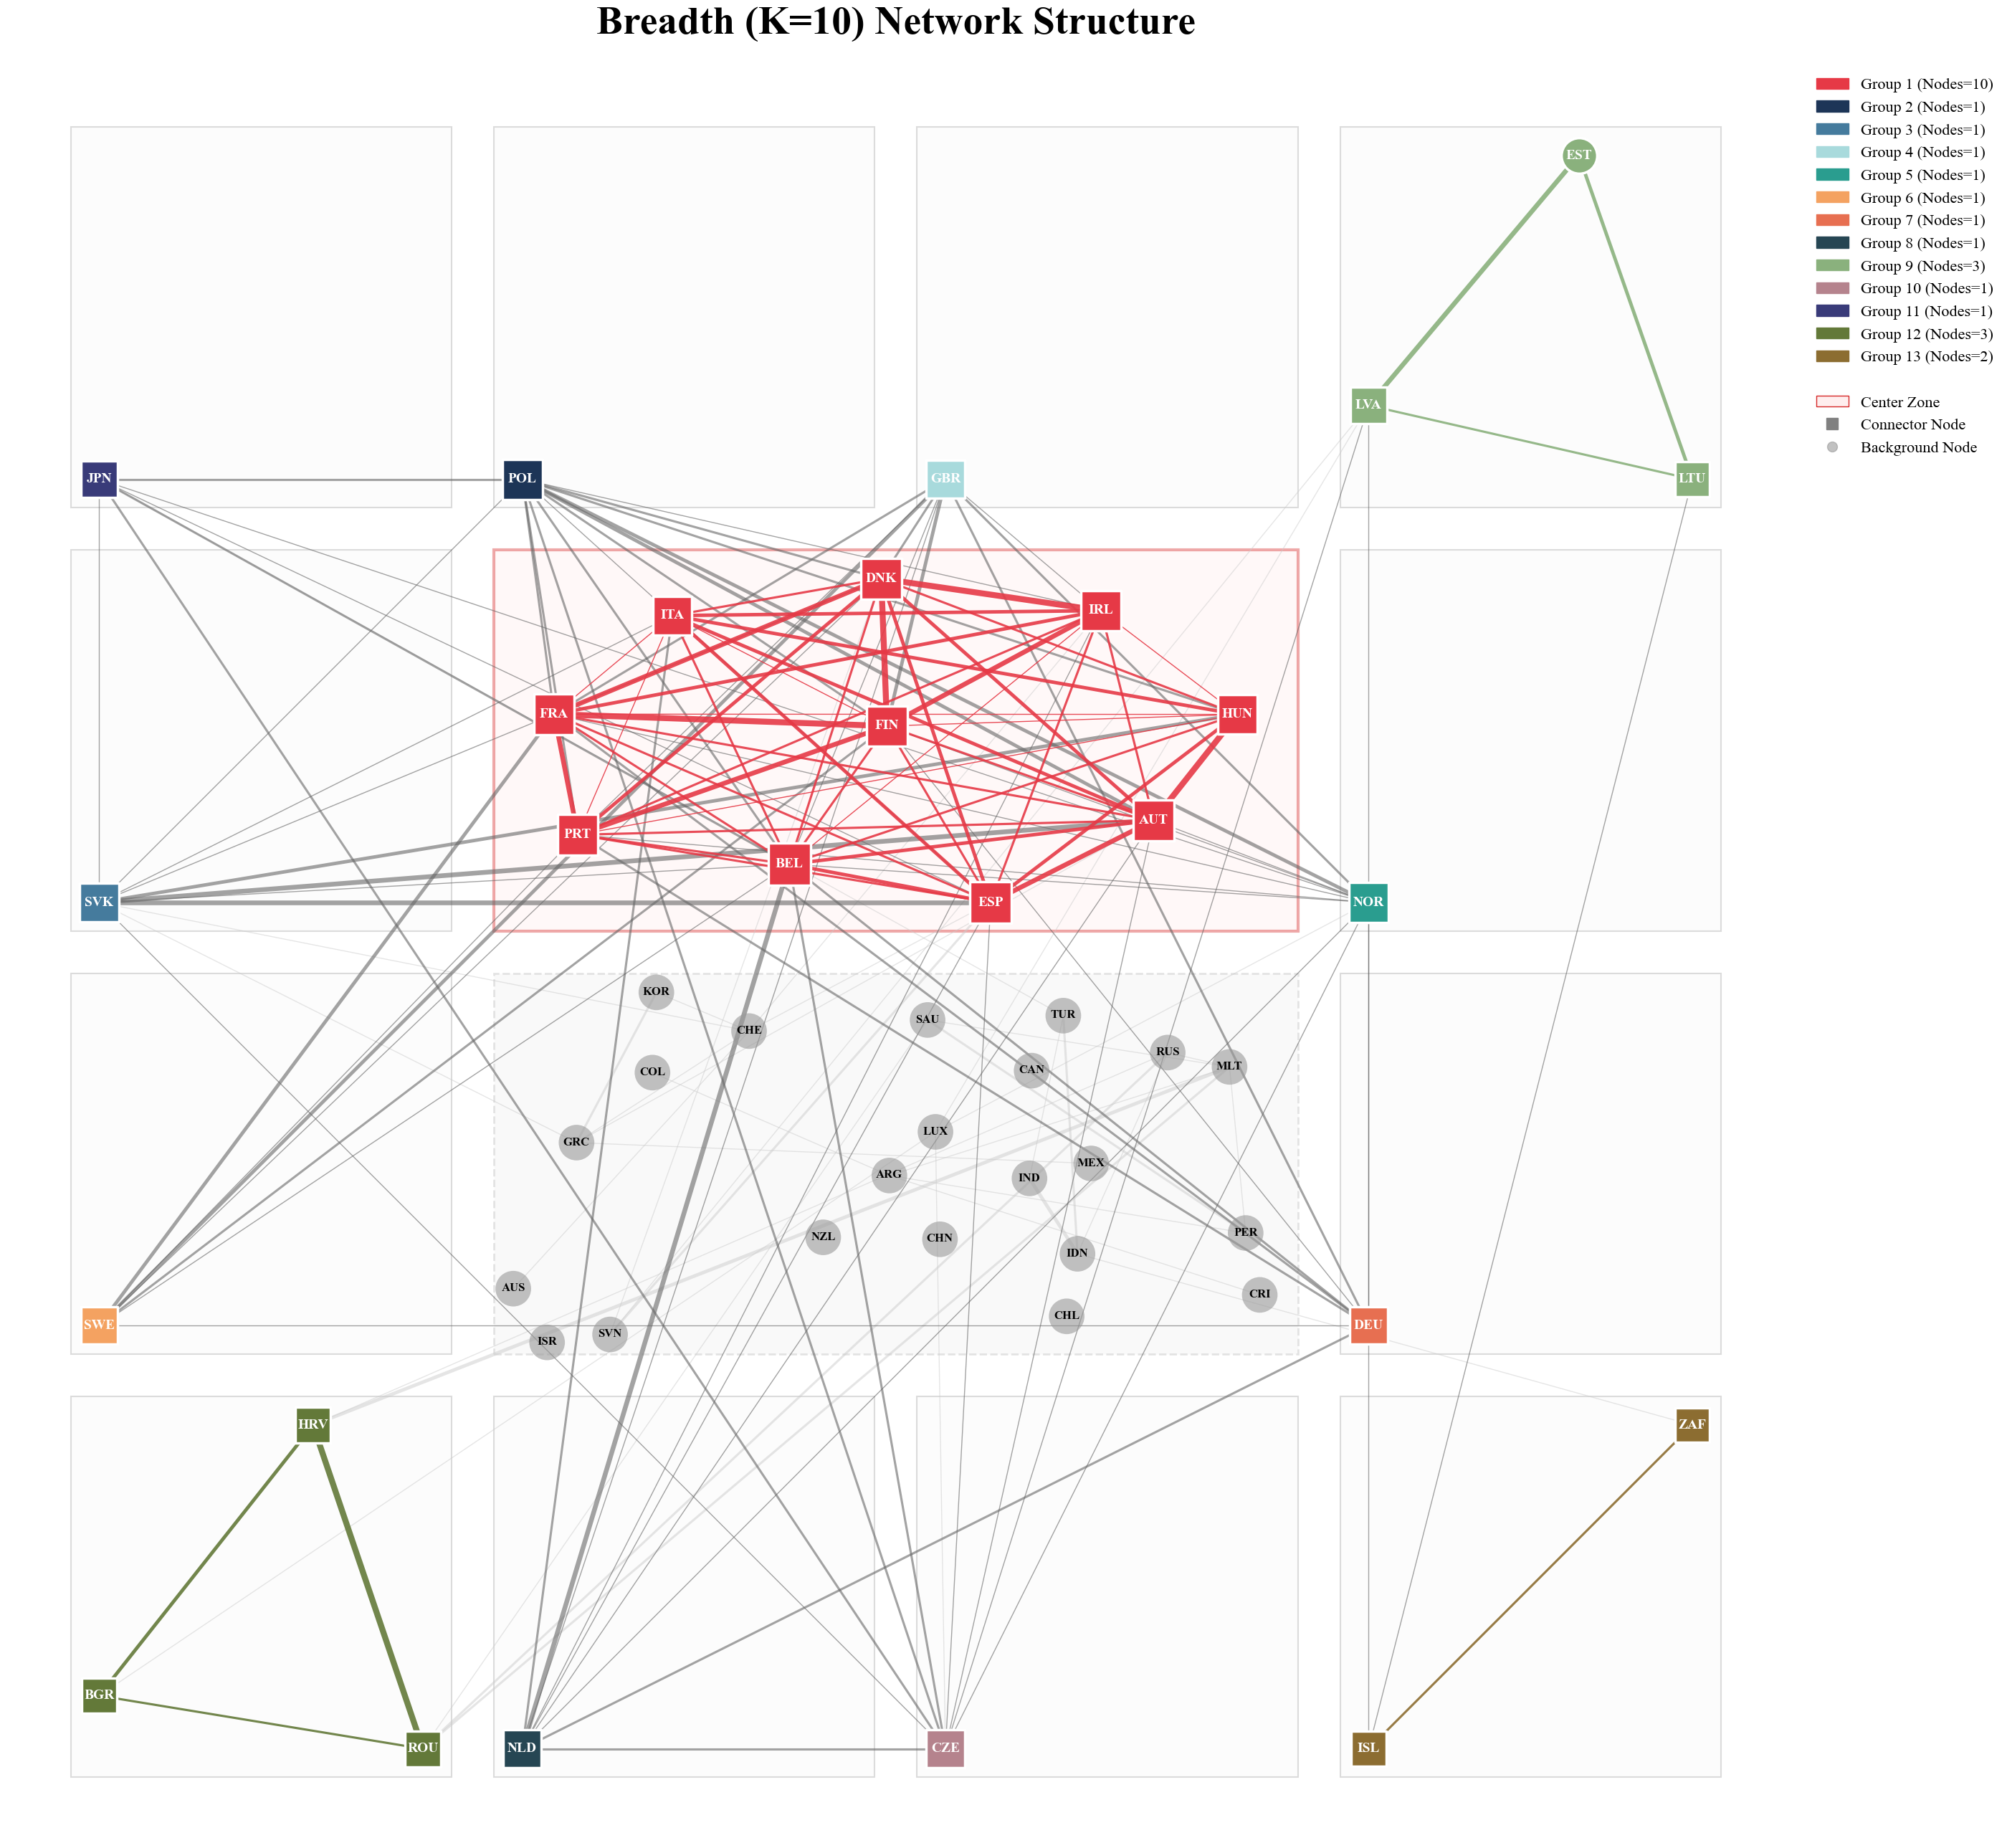


Processing Intensity...
[Saved CSV] ../data/4-1-2-clique_analysis/4-1-overlapping_cluster_heatmap_Intensity/Network\Intensity_Structure_Analysis.csv
[Saved Image] ../data/4-1-2-clique_analysis/4-1-overlapping_cluster_heatmap_Intensity/Network\Intensity_Network_Graph.png


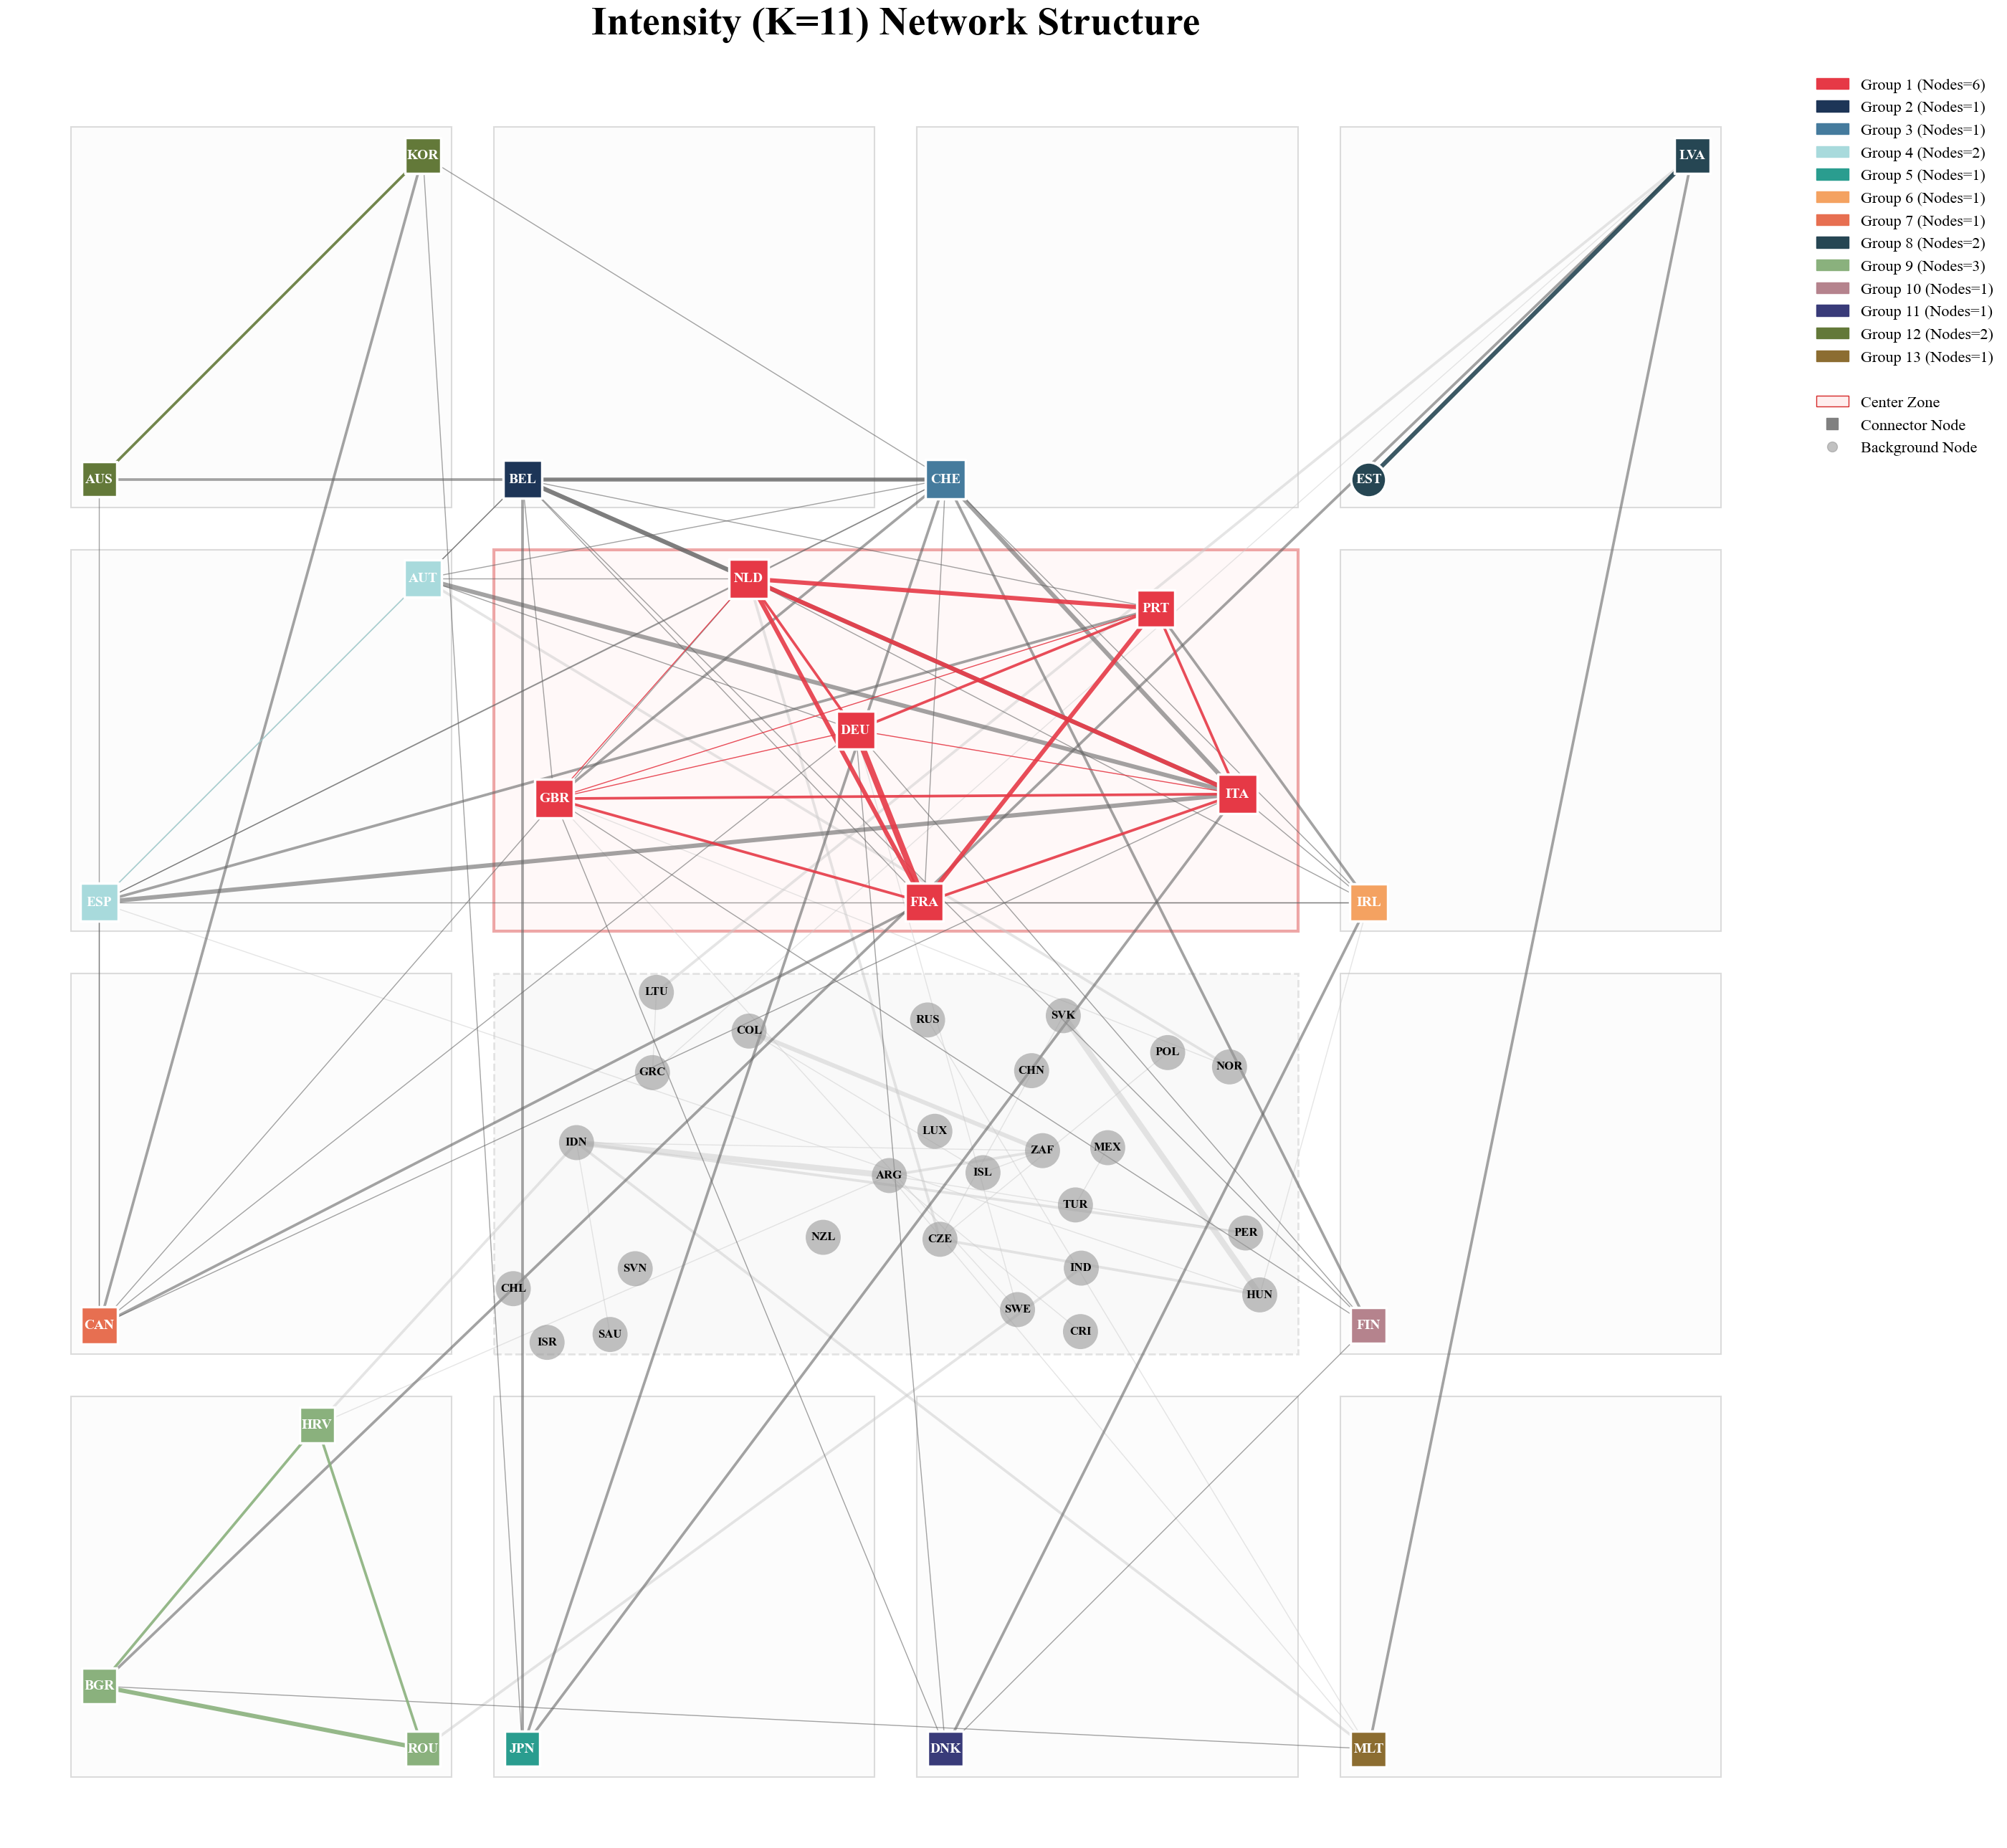

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import networkx as nx
import warnings
import math
import random
import os

warnings.filterwarnings("ignore")

# ==========================================
# 0. 路径配置 (相对路径)
# ==========================================
# 网络权重矩阵
INPUT_PATH_BREADTH = r"../data/4-1-overlapping_cluster_heatmap_Breadth.csv"
INPUT_PATH_INTENSITY = r"../data/4-1-overlapping_cluster_heatmap_Intensity.csv"

# 原始政策数据 (用于计算交集)
RAW_PATH_BREADTH = r"../data/3-1-L2_Policy_Clustering_Breadth.csv"
# 如果 Intensity 没有单独的原始文件，通常复用 Breadth 的数据
RAW_PATH_INTENSITY = r"../data/3-1-L2_Policy_Clustering_Intensity.csv" 

# 输出目录
OUTPUT_BASE_BREADTH = r"../data/4-1-2-clique_analysis/4-1-overlapping_cluster_heatmap_Breadth/Network"
OUTPUT_BASE_INTENSITY = r"../data/4-1-2-clique_analysis/4-1-overlapping_cluster_heatmap_Intensity/Network"

def ensure_dir(path):
    if not os.path.exists(path):
        try:
            os.makedirs(path)
            print(f"Directory created: {path}")
        except OSError as e:
            print(f"Error creating directory {path}: {e}")

# ==========================================
# 1. 基础配置
# ==========================================
def get_font():
    return FontProperties(family="Times New Roman", size=24, weight="black")

T_FONT = get_font()

PALETTE = [
    '#E63946', '#1D3557', '#457B9D', '#A8DADC', '#2A9D8F',
    '#F4A261', '#E76F51', '#264653', '#8AB17D', '#B5838D',
    '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173',
    '#5F0F40', '#9A031E', '#FB8B24', '#0F4C5C', '#598392' 
]

# ==========================================
# 2. 数据读取与处理
# ==========================================
def read_matrix(path):
    abs_path = os.path.abspath(path)
    if not os.path.exists(abs_path):
        raise FileNotFoundError(f"File not found: {abs_path}")
    df = pd.read_csv(abs_path, index_col=0, encoding="utf-8-sig")
    df.index = df.index.astype(str).str.strip()
    df.columns = df.columns.astype(str).str.strip()
    common = [c for c in df.columns if c in df.index]
    df = df.loc[common, common]
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    df = (df + df.T) / 2.0
    return df.round(0).astype(int)

def load_and_pivot_raw_policy(path):
    """
    读取原始长格式政策数据，转换为 (国家 x 政策) 的 0/1 矩阵
    """
    abs_path = os.path.abspath(path)
    if not os.path.exists(abs_path):
        # 尝试回退查找
        if os.path.exists(path.replace("Intensity", "Breadth")):
             print(f"Info: Using Breadth raw data as fallback for {path}")
             abs_path = os.path.abspath(path.replace("Intensity", "Breadth"))
        else:
             print(f"Warning: Raw policy file not found at {abs_path}. Intersection column will be empty.")
             return None
             
    try:
        # 读取原始数据
        # 假设列名: 国家, 年份, 占比, 聚类ID, L2政策, ...
        df = pd.read_csv(abs_path, encoding="utf-8-sig")
        
        # 聚合逻辑: 只要某国家在任一年份的某政策占比 > 0，即视为拥有该政策
        # Pivot: Index=国家, Columns=L2政策, Values=占比 (取最大值)
        if 'L2政策' not in df.columns or '国家' not in df.columns:
             print("Warning: Raw data missing '国家' or 'L2政策' columns.")
             return None
             
        pivot_df = df.pivot_table(index='国家', columns='L2政策', values='占比', aggfunc='max')
        
        # 转换为 0/1
        pivot_df = (pivot_df > 0).astype(int)
        return pivot_df
        
    except Exception as e:
        print(f"Error processing raw policy data: {e}")
        return None

def build_graph(df, k):
    countries = df.index.tolist()
    G = nx.Graph()
    G.add_nodes_from(countries)
    rows, cols = np.where(df.values >= k)
    for r, c in zip(rows, cols):
        if r < c:
            G.add_edge(countries[r], countries[c], weight=int(df.iloc[r, c]))
    return G

# ==========================================
# 3. 社区分析、排序与导出
# ==========================================
def get_clique_metrics(df, members):
    n = len(members)
    if n <= 1: return 0.0, 0.0, 0.0
    vals = df.loc[members, members].values[np.triu_indices(n, k=1)]
    if len(vals) == 0: return 0.0, 0.0, 0.0
    return n, float(np.mean(vals)), float(np.var(vals))

def get_common_policies(members, pivot_df):
    """计算组内成员的政策交集"""
    if pivot_df is None or pivot_df.empty:
        return "[Raw Data Missing]"
    
    # 筛选有效成员
    valid_members = [m for m in members if m in pivot_df.index]
    if not valid_members:
        return "None"
        
    # 提取子集
    subset = pivot_df.loc[valid_members]
    
    # 全员共有的政策：该列的和 == 成员数
    n_members = len(valid_members)
    common_mask = (subset.sum(axis=0) == n_members)
    common_policies = common_mask[common_mask].index.tolist()
    
    if not common_policies:
        return "None"
    
    return "; ".join(common_policies)

def analyze_and_rank_cliques(df, k, pivot_df=None, min_size=2, max_comms=13, output_dir=None, file_prefix=""):
    G = build_graph(df, k)
    cliques = [c for c in nx.find_cliques(G) if len(c) >= min_size]
    
    # 1. 收集数据
    clique_data = []
    for c in cliques:
        c = sorted(list(set(c)))
        n, avg, var = get_clique_metrics(df, c)
        clique_data.append({"members": c, "size": n, "avg": avg, "var": var})
    
    if not clique_data: return [], {}, G

    # 2. 评分
    sizes = np.array([x['size'] for x in clique_data])
    avgs = np.array([x['avg'] for x in clique_data])
    vars_ = np.array([x['var'] for x in clique_data])
    
    def norm(arr):
        if np.max(arr) == np.min(arr): return np.zeros_like(arr)
        return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

    s_norm = norm(sizes)
    a_norm = norm(avgs)
    v_norm = norm(vars_)
    
    for i, x in enumerate(clique_data):
        x['score'] = s_norm[i] * 1.0 + a_norm[i] * 0.8 - v_norm[i] * 0.5
        
    clique_data.sort(key=lambda x: -x['score'])
    
    # 3. 优胜劣汰 (Smart Filtering)
    final_cliques = []
    node_ownership = {}
    assigned_nodes = set()
    rank_counter = 0
    
    for data in clique_data:
        if len(final_cliques) >= max_comms: break
        
        mems = data['members']
        unique_count = 0
        temp_owned = []
        for m in mems:
            if m not in assigned_nodes:
                temp_owned.append(m)
                unique_count += 1
        
        # 强制保留第一名(Center) 或 有独特节点的组
        if unique_count > 0 or rank_counter == 0:
            for m in temp_owned:
                node_ownership[m] = rank_counter
                assigned_nodes.add(m)
            data['effective_size'] = unique_count
            data['rank'] = rank_counter
            final_cliques.append(data)
            rank_counter += 1
            
    # 4. 导出 CSV
    if output_dir:
        ensure_dir(output_dir)
        export_data = []
        for i, data in enumerate(final_cliques):
            owned_members = [n for n, r in node_ownership.items() if r == i]
            
            # 计算政策交集 (基于全员, 还是基于专属成员? 通常基于全员 Full Members 更有意义)
            # 这里我们基于 Full Members 计算交集
            intersection_str = get_common_policies(data['members'], pivot_df)
            
            export_data.append({
                "Rank": i + 1,
                "Unique Countries": ", ".join(owned_members),
                "Full Members": ", ".join(data['members']),
                "Node Count (Unique)": data['effective_size'],
                "Node Count (Total)": data['size'],
                "Avg Weight": round(data['avg'], 2),
                "Variance": round(data['var'], 4),
                "Score": round(data['score'], 4),
                "Common_Policies_Intersection": intersection_str
            })
        
        df_export = pd.DataFrame(export_data)
        csv_path = os.path.join(output_dir, f"{file_prefix}_Structure_Analysis.csv")
        df_export.to_csv(csv_path, index=False, encoding='utf-8-sig')
        print(f"[Saved CSV] {csv_path}")

    return final_cliques, node_ownership, G

# ==========================================
# 4. 核心布局：4x4 绝对阵列 (Absolute Grid)
# ==========================================
def layout_4x4_unified(G, top_cliques, node_ownership, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    CENTER_RANK = 0 
    
    # 物理参数
    CELL_SIZE = 10.0
    GAP = 0.5
    
    # 坐标辅助
    def get_cell_center(r, c):
        # r: 0(Top)..3(Bottom), c: 0(Left)..3(Right)
        # 物理坐标: y 向上为正. y = (3-r)*10 + 5. x = c*10 + 5
        return np.array([c * CELL_SIZE + CELL_SIZE/2, (3 - r) * CELL_SIZE + CELL_SIZE/2])
    
    def get_cell_bounds(r, c):
        cx, cy = get_cell_center(r, c)
        return (cx - CELL_SIZE/2 + GAP, cx + CELL_SIZE/2 - GAP, 
                cy - CELL_SIZE/2 + GAP, cy + CELL_SIZE/2 - GAP)

    # A. 区域定义
    center_coords = [(1, 1), (1, 2)] # Row 2 (index 1), Col 2-3 (index 1, 2)
    bg_coords = [(2, 1), (2, 2)]     # Row 3 (index 2), Col 2-3 (index 1, 2)
    
    normal_slots = []
    for r in range(4):
        for c in range(4):
            if (r, c) in center_coords: continue
            if (r, c) in bg_coords: continue
            normal_slots.append((r, c))
            
    # 排序: 离中心 (1.5, 1.5) 最近优先
    center_pt = np.array([1.5, 1.5])
    normal_slots.sort(key=lambda x: np.linalg.norm(np.array(x) - center_pt))
    
    # B. 分配位置
    group_locs = {}
    if len(top_cliques) > 0:
        group_locs[CENTER_RANK] = 'center'
        
    if len(top_cliques) > 1:
        center_nodes = set(top_cliques[0]['members'])
        remaining = []
        for i in range(1, len(top_cliques)):
            cid = i
            mems = top_cliques[i]['members']
            strength = 0
            for u in mems:
                for v in G.neighbors(u):
                    if v in center_nodes: strength += G[u][v]['weight']
            remaining.append((strength, cid))
        remaining.sort(key=lambda x: -x[0])
        
        for i, (w, cid) in enumerate(remaining):
            if i < len(normal_slots):
                group_locs[cid] = normal_slots[i]
                
    # C. 计算绘图边界
    bounds_map = {}
    
    # 1. 皇城 (合并大框)
    if CENTER_RANK in group_locs:
        # 左格子(1,1) 到 右格子(1,2)
        b1 = get_cell_bounds(1, 1)
        b2 = get_cell_bounds(1, 2)
        # 取并集边界
        xmin = min(b1[0], b2[0])
        xmax = max(b1[1], b2[1])
        ymin = min(b1[2], b2[2])
        ymax = max(b1[3], b2[3])
        bounds_map[CENTER_RANK] = (xmin, xmax, ymin, ymax)
        
    # 2. 卫戍 (合并大框)
    bg_bounds_map = {}
    b1 = get_cell_bounds(2, 1)
    b2 = get_cell_bounds(2, 2)
    bg_xmin = min(b1[0], b2[0])
    bg_xmax = max(b1[1], b2[1])
    bg_ymin = min(b1[2], b2[2])
    bg_ymax = max(b1[3], b2[3])
    bg_bounds_map[0] = (bg_xmin, bg_xmax, bg_ymin, bg_ymax)
    
    # 3. 普通组 (独立格子)
    for cid, slot in group_locs.items():
        if cid == CENTER_RANK: continue
        bounds_map[cid] = get_cell_bounds(slot[0], slot[1])
        
    # D. 节点布局
    final_pos = {}
    
    # 组内布局
    for rank, bounds in bounds_map.items():
        members = [n for n, r in node_ownership.items() if r == rank]
        if not members: continue
        
        sub_g = G.subgraph(members)
        sub_pos = nx.spring_layout(sub_g, k=1.0, seed=seed)
        
        pts = np.array(list(sub_pos.values()))
        if len(pts) > 0:
            min_xy, max_xy = pts.min(axis=0), pts.max(axis=0)
            span = max_xy - min_xy
            span[span==0] = 1.0
            
            bx_min, bx_max, by_min, by_max = bounds
            target_w = (bx_max - bx_min) * 0.85
            target_h = (by_max - by_min) * 0.85
            cx = (bx_min + bx_max) / 2
            cy = (by_min + by_max) / 2
            
            for n, p in sub_pos.items():
                norm_x = (p[0] - min_xy[0]) / span[0]
                norm_y = (p[1] - min_xy[1]) / span[1]
                fx = cx + (norm_x - 0.5) * target_w
                fy = cy + (norm_y - 0.5) * target_h
                final_pos[n] = np.array([fx, fy])

    # 背景布局
    bg_nodes = [n for n in G.nodes() if n not in final_pos]
    if bg_nodes and 0 in bg_bounds_map:
        bounds = bg_bounds_map[0]
        sub_pos = nx.spring_layout(nx.Graph(), center=(0,0), k=2.0, iterations=100)
        # 补漏
        for n in bg_nodes:
            if n not in sub_pos: sub_pos[n] = np.random.rand(2)

        bx_min, bx_max, by_min, by_max = bounds
        cx = (bx_min + bx_max) / 2
        cy = (by_min + by_max) / 2
        
        pts = np.array([sub_pos[n] for n in bg_nodes])
        if len(pts) > 0:
            min_xy, max_xy = pts.min(axis=0), pts.max(axis=0)
            span = max_xy - min_xy
            span[span==0] = 1.0
            target_w = (bx_max - bx_min) * 0.9
            target_h = (by_max - by_min) * 0.9
            
            for n in bg_nodes:
                p = sub_pos[n]
                norm_x = (p[0] - min_xy[0]) / span[0]
                norm_y = (p[1] - min_xy[1]) / span[1]
                fx = cx + (norm_x - 0.5) * target_w
                fy = cy + (norm_y - 0.5) * target_h
                final_pos[n] = np.array([fx, fy])

    final_pos = resolve_overlaps(final_pos, min_dist=1.5)
    return final_pos, bounds_map, bg_bounds_map, node_ownership

def resolve_overlaps(pos, iterations=50, min_dist=1.2):
    nodes = list(pos.keys())
    if not nodes: return {}
    pts = np.array([pos[n] for n in nodes])
    for _ in range(iterations):
        moved = False
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                diff = pts[i] - pts[j]
                dist = np.linalg.norm(diff)
                if dist < min_dist:
                    if dist < 0.01: diff = np.random.rand(2) * 0.01
                    force = (diff / (dist + 1e-9)) * (min_dist - dist) * 0.5
                    pts[i] += force
                    pts[j] -= force
                    moved = True
        if not moved: break
    for i, n in enumerate(nodes): pos[n] = pts[i]
    return pos

# ==========================================
# 6. 绘图主程序 (Clean & Centered)
# ==========================================
def draw_network_final(df, k, pivot_df=None, title_suffix="", seed=42, output_dir=None, file_prefix=""):
    
    top_cliques, node_ownership, G = analyze_and_rank_cliques(
        df, k, pivot_df=pivot_df, min_size=2, max_comms=13, output_dir=output_dir, file_prefix=file_prefix
    )
    
    if not top_cliques:
        print(f"No communities found for {title_suffix}.")
        return

    pos, bounds_map, bg_bounds_map, node_ownership = layout_4x4_unified(G, top_cliques, node_ownership, seed=seed)

    fig, ax = plt.subplots(figsize=(28, 28))
    
    # ----------------------------------------------------
    # A. 绘制框 (只画活跃的, 没有统一的底层 Grid)
    # ----------------------------------------------------
    
    # 1. 皇城 (Center) - 横跨两列
    if 0 in bounds_map:
        b = bounds_map[0]
        rect = mpatches.Rectangle((b[0], b[2]), b[1]-b[0], b[3]-b[2],
                                  fill=True, facecolor='#FFEEEE', edgecolor='#D62828', linewidth=3, alpha=0.4, zorder=0)
        ax.add_patch(rect)
        
    # 2. 卫戍 (Background) - 横跨两列
    if 0 in bg_bounds_map:
        b = bg_bounds_map[0]
        rect = mpatches.Rectangle((b[0], b[2]), b[1]-b[0], b[3]-b[2],
                                  fill=True, facecolor='#EEEEEE', edgecolor='#AAAAAA', linestyle='--', linewidth=2, alpha=0.3, zorder=0)
        ax.add_patch(rect)
        
    # 3. 普通组 (Normal) - 独立小格子
    for rank, b in bounds_map.items():
        if rank == 0: continue
        rect = mpatches.Rectangle((b[0], b[2]), b[1]-b[0], b[3]-b[2],
                                  fill=True, facecolor='#F4F4F4', edgecolor='#555555', linewidth=1.5, alpha=0.2, zorder=0)
        ax.add_patch(rect)

    # B. 边
    all_weights = [d['weight'] for u, v, d in G.edges(data=True)]
    if not all_weights: all_weights = [1]
    min_w, max_w = min(all_weights), max(all_weights)
    def get_width(w): return 1.0 + (w - min_w) / (max_w - min_w) * 5.0

    inter_edges, intra_edges, bg_edges = [], [], []
    for u, v, d in G.edges(data=True):
        if u not in pos or v not in pos: continue
        w = d.get('weight', 1)
        width = get_width(w)
        owner_u = node_ownership.get(u, -1)
        owner_v = node_ownership.get(v, -1)
        
        if owner_u != -1 and owner_v != -1:
            if owner_u == owner_v:
                col = PALETTE[owner_u % len(PALETTE)]
                intra_edges.append((u, v, width, col))
            else:
                inter_edges.append((u, v, width))
        else:
            bg_edges.append((u, v, width))

    if bg_edges:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,w in bg_edges], width=[w for u,v,w in bg_edges], edge_color="#CCCCCC", alpha=0.5, ax=ax)
    if inter_edges:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v) for u,v,w in inter_edges], width=[w for u,v,w in inter_edges], edge_color="#666666", alpha=0.6, ax=ax)
    for u, v, w, col in intra_edges:
        nx.draw_networkx_edges(G, pos, edgelist=[(u,v)], width=w, edge_color=col, alpha=0.9, ax=ax)

    # C. 节点
    comm_nodes = [n for n in G.nodes() if n in node_ownership]
    min_comm_size = 1200
    if comm_nodes:
        sizes = [1200 + 40 * G.degree(n) for n in comm_nodes]
        min_comm_size = min(sizes) if sizes else 1200
        rect_nodes, circle_nodes = [], []
        for n in comm_nodes:
            rank = node_ownership[n]
            is_conn = False
            for nb in G.neighbors(n):
                if node_ownership.get(nb, -1) != rank:
                    is_conn = True
                    break
            if is_conn: rect_nodes.append(n)
            else: circle_nodes.append(n)
            
        if circle_nodes:
            cols = [PALETTE[node_ownership[n]%len(PALETTE)] for n in circle_nodes]
            sz = [1200 + 40 * G.degree(n) for n in circle_nodes]
            nx.draw_networkx_nodes(G, pos, nodelist=circle_nodes, node_color=cols, node_size=sz, node_shape='o', edgecolors='white', linewidths=2.5, ax=ax)
            nx.draw_networkx_labels(G, pos, labels={n:n for n in circle_nodes}, font_family="Times New Roman", font_size=14, font_color="white", font_weight="bold", ax=ax)
        if rect_nodes:
            cols = [PALETTE[node_ownership[n]%len(PALETTE)] for n in rect_nodes]
            sz = [1100 + 40 * G.degree(n) for n in rect_nodes]
            nx.draw_networkx_nodes(G, pos, nodelist=rect_nodes, node_color=cols, node_size=sz, node_shape='s', edgecolors='white', linewidths=2.5, ax=ax)
            nx.draw_networkx_labels(G, pos, labels={n:n for n in rect_nodes}, font_family="Times New Roman", font_size=14, font_color="white", font_weight="bold", ax=ax)

    bg_nodes_list = [n for n in G.nodes() if n not in node_ownership]
    if bg_nodes_list:
        nx.draw_networkx_nodes(G, pos, nodelist=bg_nodes_list, node_color="#999999", node_size=min_comm_size, edgecolors='none', alpha=0.6, ax=ax)
        nx.draw_networkx_labels(G, pos, labels={n:n for n in bg_nodes_list}, font_family="Times New Roman", font_size=12, font_color="black", font_weight="bold", ax=ax)

    # D. 图例
    handles = []
    for i, data in enumerate(top_cliques):
        col = PALETTE[i%len(PALETTE)]
        eff_n = data.get('effective_size', 0)
        handles.append(mpatches.Patch(color=col, label=f"Group {i+1} (Nodes={eff_n})"))
        
    handles.append(mpatches.Patch(color="none", label=" "))
    handles.append(mpatches.Patch(facecolor='#FFEEEE', edgecolor='#D62828', label='Center Zone'))
    handles.append(mlines.Line2D([], [], color='gray', marker='s', linestyle='None', markersize=12, label="Connector Node"))
    handles.append(mlines.Line2D([], [], color='#999999', marker='o', linestyle='None', markersize=10, alpha=0.6, label="Background Node"))
    
    plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False, prop={'family': 'Times New Roman', 'size': 16})
    plt.title(f"{title_suffix} Network Structure", fontproperties=T_FONT, fontsize=40, pad=30)
    plt.axis("off")
    
    # 锁定完美居中
    # 网格范围: x[0, 40], y[0, 40]
    # 视野: [-1, 41]
    ax.set_xlim(-1, 41)
    ax.set_ylim(-1, 41)
    ax.set_aspect("equal")

    plt.tight_layout()
    
    if output_dir:
        ensure_dir(output_dir)
        img_path = os.path.join(output_dir, f"{file_prefix}_Network_Graph.png")
        plt.savefig(img_path, dpi=300, bbox_inches='tight')
        print(f"[Saved Image] {img_path}")

    plt.show()

# ==========================================
# 执行
# ==========================================
if __name__ == "__main__":
    try:
        # Load Pivot Data
        print("Loading Policy Data...")
        pivot_breadth = load_and_pivot_raw_policy(RAW_PATH_BREADTH)
        pivot_intensity = load_and_pivot_raw_policy(RAW_PATH_INTENSITY)
        
        # fallback
        if pivot_intensity is None and pivot_breadth is not None:
            pivot_intensity = pivot_breadth

        print("\nProcessing Breadth...")
        df_b = read_matrix(INPUT_PATH_BREADTH)
        draw_network_final(df_b, k=10, pivot_df=pivot_breadth,
                           title_suffix="Breadth (K=10)", seed=101, 
                           output_dir=OUTPUT_BASE_BREADTH, file_prefix="Breadth")
        
        print("\nProcessing Intensity...")
        df_i = read_matrix(INPUT_PATH_INTENSITY)
        draw_network_final(df_i, k=11, pivot_df=pivot_intensity,
                           title_suffix="Intensity (K=11)", seed=101, 
                           output_dir=OUTPUT_BASE_INTENSITY, file_prefix="Intensity")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")

#### 多种类测试

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
from pathlib import Path
import colorsys
import warnings
import re
from joblib import Parallel, delayed
import networkx as nx
import matplotlib.patches as mpatches

warnings.filterwarnings("ignore")

# ==========================================
# 1) 基础配置 & 画图风格 (保持不变)
# ==========================================
current_dir = Path.cwd()
data_root = current_dir.parent / "data" / "4-1-overlapping_cluster_heatmap"
base_output_dir = current_dir.parent / "data" / "4-2-final_clique_analysis"
base_output_dir.mkdir(parents=True, exist_ok=True)

def get_times_black_font():
    return FontProperties(family="Times New Roman", size=26, weight="black")

T_BLACK = get_times_black_font()

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.weight": "black",
    "axes.labelweight": "black",
    "axes.titleweight": "black",
    "axes.unicode_minus": False,
    "figure.dpi": 300
})

sns.set_theme(style="white")
plt.rcParams["axes.axisbelow"] = False

def lighten_color_slightly(hex_color: str) -> str:
    r, g, b = plt.cm.colors.to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return plt.cm.colors.to_hex(colorsys.hls_to_rgb(h, min(1.0, l + 0.12), s * 0.88))

def get_palette(k: int) -> list:
    base_colors = [
        '#E63946', '#1D3557', '#457B9D', '#A8DADC', '#2A9D8F', 
        '#F4A261', '#E76F51', '#264653', '#8AB17D', '#B5838D',
        '#393b79', '#637939', '#8c6d31', '#843c39', '#7b4173'
    ]
    if k <= len(base_colors):
        return base_colors[:k]
    return (base_colors * (k // len(base_colors) + 1))[:k]

def slugify(name: str) -> str:
    s = re.sub(r"[^\w\-]+", "_", name.strip())
    s = re.sub(r"_+", "_", s).strip("_")
    return s if s else "unnamed"

# ==========================================
# 2) 关键参数
# ==========================================
THRESHOLD_MODE = "count"
K_LIST_COUNT = list(range(5, 16))
K_LIST_PERCENT = [0.30, 0.40, 0.50, 0.60, 0.70]
MIN_CLIQUE_SIZE = 3
PERCENT_DENOM = "min_diag"

# ==========================================
# 3) 数据读入与构建图
# ==========================================
def read_symmetric_matrix(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path, index_col=0, encoding="utf-8-sig")
    df.index = df.index.astype(str).str.strip()
    df.columns = df.columns.astype(str).str.strip()
    common = [c for c in df.columns if c in df.index]
    df = df.loc[common, common]
    df = df.apply(pd.to_numeric, errors="coerce").fillna(0)
    df = (df + df.T) / 2.0
    df = df.round(0).astype(int)
    return df

def build_normalized_matrix(df_o: pd.DataFrame) -> pd.DataFrame:
    A = df_o.values.astype(float)
    diag = np.diag(A).astype(float)
    if PERCENT_DENOM == "min_diag":
        denom = np.minimum.outer(diag, diag)
    elif PERCENT_DENOM == "max_diag":
        denom = np.maximum.outer(diag, diag)
    else:
        denom = np.full_like(A, fill_value=float(np.max(A)))
    with np.errstate(divide="ignore", invalid="ignore"):
        norm = np.where(denom > 0, A / denom, 0.0)
    np.fill_diagonal(norm, 1.0)
    return pd.DataFrame(norm, index=df_o.index, columns=df_o.columns)

def build_threshold_graph(df_o: pd.DataFrame, k: float, mode: str, df_norm: pd.DataFrame | None = None) -> nx.Graph:
    countries = df_o.index.tolist()
    if mode == "count":
        cond = (df_o.values >= float(k))
    else:
        cond = (df_norm.values >= float(k))
    
    np.fill_diagonal(cond, False)
    G = nx.Graph()
    G.add_nodes_from(countries)
    rows, cols = np.where(cond)
    for r, c in zip(rows, cols):
        if r < c:
            G.add_edge(countries[r], countries[c])
    return G

# ==========================================
# 4) 核心算法：三维排序 + 增量覆盖
# ==========================================
def get_clique_metrics(df_o: pd.DataFrame, members: list) -> tuple[int, float, float]:
    """计算团的三维指标：Size, Sum Weight, Variance"""
    n = len(members)
    if n < 2: return n, 0.0, 0.0
    sub = df_o.loc[members, members].values
    # 取上三角部分的边权重（不含对角线）
    vals = sub[np.triu_indices(n, k=1)]
    
    if len(vals) == 0: return n, 0.0, 0.0
    
    size = n
    sum_weight = float(np.sum(vals))
    # 计算方差，衡量稳定性 (越小越稳定)
    variance = float(np.var(vals))
    
    return size, sum_weight, variance

def find_final_cliques(df_o: pd.DataFrame, k: float, mode: str, df_norm: pd.DataFrame | None) -> pd.DataFrame:
    # 1. 找到所有最大团
    G = build_threshold_graph(df_o, k, mode, df_norm)
    all_maximal = list(nx.find_cliques(G))
    candidates = [c for c in all_maximal if len(c) >= MIN_CLIQUE_SIZE]
    
    if not candidates: return pd.DataFrame()

    # 2. 计算三维指标
    cand_objs = []
    for c in candidates:
        s, sum_w, var_w = get_clique_metrics(df_o, c)
        cand_objs.append({
            "members_list": c,
            "size": s,
            "sum_weight": sum_w,
            "variance": var_w
        })
    
    # 3. 全局排序：Size(降) -> Sum(降) -> Variance(升)
    # 使用负号来实现降序
    cand_objs.sort(key=lambda x: (-x["size"], -x["sum_weight"], x["variance"]))
    
    # 4. 增量覆盖筛选
    accepted_cliques = []
    global_visited = set()
    
    for cand in cand_objs:
        c_nodes = set(cand["members_list"])
        new_nodes = c_nodes - global_visited
        
        # 如果没有贡献任何新节点，丢弃
        if len(new_nodes) == 0:
            continue
            
        # 录取
        accepted_cliques.append({
            "members": ", ".join(sorted(list(c_nodes))),
            "size": cand["size"],
            "sum_weight": cand["sum_weight"],
            "variance": cand["variance"],
            "new_nodes_count": len(new_nodes),
            "new_nodes": ", ".join(sorted(list(new_nodes)))
        })
        global_visited.update(c_nodes)
    
    if not accepted_cliques: return pd.DataFrame()

    df_res = pd.DataFrame(accepted_cliques)
    df_res["CliqueID"] = range(1, len(df_res) + 1)
    # 调整列顺序方便查看
    return df_res[["CliqueID", "size", "sum_weight", "variance", "new_nodes_count", "members"]]

# ==========================================
# 5) 画图 A：热力图 (保持原风格)
# ==========================================
def order_for_heatmap(df_o: pd.DataFrame, cliques_list: list[list[str]]) -> list[str]:
    ordered = []
    used = set()
    # 按团的顺序，尽量把团内成员排在一起
    for c in cliques_list:
        new_mems = [m for m in c if m in df_o.index and m not in used]
        if not new_mems: continue
        # 团内局部按强度排序
        sub = df_o.loc[new_mems, new_mems]
        w = sub.sum(axis=1).sort_values(ascending=False)
        m_sorted = w.index.tolist()
        ordered.extend(m_sorted)
        used.update(m_sorted)
    # 剩下的节点
    rest = [x for x in df_o.index if x not in used]
    if rest:
        w = df_o.loc[rest, rest].sum(axis=1).sort_values(ascending=False)
        ordered.extend(w.index.tolist())
    return ordered

def draw_clique_heatmap(df_o: pd.DataFrame, df_res: pd.DataFrame, out_png: Path, title: str):
    if df_res.empty: return

    cliques_to_draw = []
    for _, row in df_res.iterrows():
        val = str(row["members"])
        cliques_to_draw.append([x.strip() for x in val.split(",") if x.strip()])

    n = df_o.shape[0]
    max_o = int(df_o.values.max())
    size = max(18, n * 0.72)

    order = order_for_heatmap(df_o, cliques_to_draw)
    df_plot = df_o.loc[order, order]

    palette = get_palette(len(cliques_to_draw))
    default_gray = "#B0B0B0"
    color_map = {m: default_gray for m in order}
    
    # 染色：优先染排名靠前的团的颜色 (倒序遍历)
    seen_nodes = set()
    top_n_color = min(len(cliques_to_draw), 15)
    for i in range(top_n_color - 1, -1, -1):
        c = cliques_to_draw[i]
        col = lighten_color_slightly(palette[i % len(palette)])
        for m in c:
            color_map[m] = col

    row_colors = pd.Series([color_map[m] for m in df_plot.index], index=df_plot.index)

    g = sns.clustermap(
        df_plot,
        row_cluster=False, col_cluster=False,
        cmap="RdYlBu_r",
        row_colors=row_colors, col_colors=row_colors,
        dendrogram_ratio=0.01, linewidths=0.5,
        figsize=(size, size),
        annot=True, fmt="d",
        vmin=0, vmax=max_o,
        annot_kws={"fontsize": 28, "weight": "black", "fontproperties": T_BLACK},
        cbar_kws={"ticks": [0, int(max_o * 0.25), int(max_o * 0.5), int(max_o * 0.75), max_o]},
        tree_kws={"linewidths": 0} # 隐藏树状图线条
    )

    # Colorbar style
    hm_pos = g.ax_heatmap.get_position()
    pad = 0.04; cbar_w = 0.018; cbar_h = hm_pos.height * 0.78
    cbar_y = hm_pos.y0 + hm_pos.height * 0.11
    g.cax.set_position([hm_pos.x1 + pad, cbar_y, cbar_w, cbar_h])
    g.cax.yaxis.set_label_position("right")
    g.cax.set_axisbelow(False)
    g.cax.tick_params(axis="y", direction="in", length=12, width=3, colors="black", right=True, pad=6)
    g.cax.set_ylabel(f"Overlap Count ({title})", fontproperties=T_BLACK, fontsize=32, weight="black", labelpad=20)
    plt.setp(g.cax.get_yticklabels(), fontproperties=T_BLACK, fontsize=28, weight="black")

    # Axis labels style
    for lab in g.ax_heatmap.get_xticklabels():
        lab.set_fontproperties(T_BLACK); lab.set_rotation(45); lab.set_ha("right")
    for lab in g.ax_heatmap.get_yticklabels():
        lab.set_fontproperties(T_BLACK); lab.set_rotation(0)

    # Spines
    ax = g.ax_heatmap
    for spine in ax.spines.values():
        spine.set_visible(True); spine.set_linewidth(4); spine.set_edgecolor("black")

    # 画框：只画排名前几且比较连续的
    boundary_color = "#4D4D4D"
    node_to_idx = {n: i for i, n in enumerate(order)}
    
    for i in range(min(10, len(cliques_to_draw))):
        c = cliques_to_draw[i]
        idxs = [node_to_idx[m] for m in c if m in node_to_idx]
        if not idxs: continue
        min_i, max_i = min(idxs), max(idxs)
        # 允许少量不连续 (容忍度为2)
        if max_i - min_i + 1 <= len(idxs) + 2:
            s, e = min_i, max_i
            ax.plot([s, s], [s, e + 1], color=boundary_color, linewidth=6, clip_on=False, zorder=20)
            ax.plot([e + 1, e + 1], [s, e + 1], color=boundary_color, linewidth=6, clip_on=False, zorder=20)
            ax.plot([s, e + 1], [s, s], color=boundary_color, linewidth=6, clip_on=False, zorder=20)
            ax.plot([s, e + 1], [e + 1, e + 1], color=boundary_color, linewidth=6, clip_on=False, zorder=20)

    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.close("all")

# ==========================================
# 6) 画图 B：网络拓扑图 (饼图节点展示重叠)
# ==========================================
def draw_pie_marker(ax, x, y, ratios, colors, size):
    """在指定位置画一个饼图节点"""
    # 计算半径 (size 是点的面积，开方得到相对半径)
    radius = np.sqrt(size) / 180.0 
    current_angle = 0
    for ratio, color in zip(ratios, colors):
        if ratio <= 0.001: continue # 忽略太小的部分
        angle = ratio * 360
        # 画扇形
        wedge = mpatches.Wedge((x, y), radius, current_angle, current_angle + angle, facecolor=color, edgecolor='none')
        ax.add_patch(wedge)
        current_angle += angle
    # 画一个白圈边框，增加区分度
    circle = mpatches.Circle((x, y), radius, facecolor='none', edgecolor='white', linewidth=1.5, zorder=10)
    ax.add_patch(circle)

def draw_network_piechart(df_o: pd.DataFrame, df_res: pd.DataFrame, G_full: nx.Graph, out_path: Path, title: str):
    if df_res.empty: return

    # 1. 建立映射：节点 -> {所属团ID: 1}
    node_clique_map = {}
    accepted_cliques = []
    for i, row in df_res.iterrows():
        mems = [x.strip() for x in str(row["members"]).split(",") if x.strip()]
        accepted_cliques.append(mems)
        for m in mems:
            if m not in node_clique_map: node_clique_map[m] = {}
            # 记录该节点属于第 i 个团
            node_clique_map[m][i] = 1

    valid_nodes = list(node_clique_map.keys())
    subG = G_full.subgraph(valid_nodes)
    if len(subG) == 0: return

    fig, ax = plt.subplots(figsize=(20, 18))
    
    # 2. 布局计算：增强团内引力
    pos_G = subG.copy()
    for i, mems in enumerate(accepted_cliques):
        # 排名越靠前的大团，内部引力越强
        w_boost = 4.0 if i < 3 else (2.0 if i < 8 else 1.2)
        for idx_u in range(len(mems)):
            for idx_v in range(idx_u + 1, len(mems)):
                u, v = mems[idx_u], mems[idx_v]
                if pos_G.has_edge(u, v):
                    pos_G[u][v]['weight'] = pos_G[u][v].get('weight', 1.0) * w_boost
    
    # 使用弹簧布局，迭代次数多一些让它稳定
    pos = nx.spring_layout(pos_G, k=1.0/np.sqrt(len(valid_nodes)), iterations=150, seed=42, weight='weight')

    palette = get_palette(len(df_res))
    
    # 3. 画边
    intra_edges = []
    intra_colors = []
    inter_edges = []
    
    for u, v in subG.edges():
        u_cs = set(node_clique_map[u].keys())
        v_cs = set(node_clique_map[v].keys())
        common = u_cs.intersection(v_cs)
        if common:
            # 如果两节点同属一个团，用排名最前的团颜色画边
            pri_c = min(common)
            intra_edges.append((u, v))
            intra_colors.append(palette[pri_c % len(palette)])
        else:
            inter_edges.append((u, v))

    # 背景边（团间）
    nx.draw_networkx_edges(subG, pos, edgelist=inter_edges, edge_color="#E0E0E0", width=1.0, alpha=0.4, ax=ax)
    # 核心边（团内）
    nx.draw_networkx_edges(subG, pos, edgelist=intra_edges, edge_color=intra_colors, width=2.5, alpha=0.7, ax=ax)

    # 4. 画饼图节点
    num_cliques = len(df_res)
    for n in subG.nodes():
        x, y = pos[n]
        clique_counts = node_clique_map[n]
        overlap_count = len(clique_counts)
        
        # 计算饼图比例 (属于哪个团就有那个团的份额)
        ratios = [clique_counts.get(i, 0) / overlap_count for i in range(num_cliques)]
        colors = [palette[i % len(palette)] for i in range(num_cliques)]
        
        # 节点大小与重叠度成正比
        base_size = 600
        size = base_size + (overlap_count - 1) * 500
        
        draw_pie_marker(ax, x, y, ratios, colors, size)

    # 5. 标签与图例
    # 标签加个白色描边，防止看不清
    text_items = nx.draw_networkx_labels(subG, pos, font_family="Times New Roman", font_size=13, font_weight="bold", ax=ax)
    for t in text_items.values():
        t.set_path_effects([plt.matplotlib.patheffects.withStroke(linewidth=3, foreground='white')])

    legend_patches = []
    for i, row in df_res.iterrows():
        if i >= 15: break # 图例只显示前15个
        cid = row["CliqueID"]
        c_color = palette[i % len(palette)]
        # 图例显示：ID (规模, 总权重)
        lbl = f"C{cid} (N={row['size']}, Sum={int(row['sum_weight'])})"
        legend_patches.append(mpatches.Patch(color=c_color, label=lbl))
    
    plt.legend(handles=legend_patches, title="Cliques (Sorted: Size->Sum->Var)", 
               bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False,
               prop={'family': 'Times New Roman', 'size': 14})
    
    plt.title(f"Network Structure: {title}\n(Pie-chart nodes indicate clique overlaps)", fontproperties=T_BLACK, fontsize=24, pad=20)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

# ==========================================
# 7) 流程控制
# ==========================================
def process_one_threshold(df_o, df_norm, k, mode, out_dir, fig_title):
    # 核心：调用新的筛选函数
    df_res = find_final_cliques(df_o, k, mode, df_norm)
    
    tag = f"K_count={int(k)}" if mode == "count" else f"K_percent={k:.2f}"
    out_csv = out_dir / f"cliques_{tag}.csv"
    df_res.to_csv(out_csv, index=False, encoding="utf-8-sig")
    
    if df_res.empty:
        return f"⚪ {fig_title} | {tag} | No valid cliques."

    # 画图
    out_hm = out_dir / f"heatmap_{tag}.png"
    draw_clique_heatmap(df_o, df_res, out_hm, f"{fig_title} {tag}")
    
    G_vis = build_threshold_graph(df_o, k, mode, df_norm)
    out_net = out_dir / f"network_pie_{tag}.png"
    # 调用新的饼图网络绘制函数
    draw_network_piechart(df_o, df_res, G_vis, out_net, f"{fig_title} {tag}")

    return f"✅ {fig_title} | {tag} | Selected {len(df_res)} cliques."

def process_one_matrix(csv_path: Path, dim_name: str):
    df_o = read_symmetric_matrix(csv_path)
    df_norm = build_normalized_matrix(df_o) if THRESHOLD_MODE == "percent" else None

    file_stem = slugify(csv_path.stem)
    out_dir = base_output_dir / dim_name / file_stem
    out_dir.mkdir(parents=True, exist_ok=True)
    
    fig_title = f"{dim_name}-{csv_path.stem}"
    k_list = K_LIST_COUNT if THRESHOLD_MODE == "count" else K_LIST_PERCENT

    print(f"\n🚀 Matrix: {fig_title}")
    
    # 并行计算
    results = Parallel(n_jobs=-1, verbose=0)(
        delayed(process_one_threshold)(
            df_o, df_norm, k, THRESHOLD_MODE, out_dir, fig_title
        ) for k in k_list
    )
    for r in results: print(r)

def main():
    if not data_root.exists():
        print(f"❌ Data root not found: {data_root}")
        return

    for dim in ["Breadth", "Intensity"]:
        dim_dir = data_root / dim
        if not dim_dir.exists(): continue
        for csv_path in sorted(dim_dir.glob("*.csv")):
            process_one_matrix(csv_path, dim)

    print("\n✨ Final Clique Analysis (Pie-Chart Network) Completed!")

if __name__ == "__main__":
    main()


🚀 Matrix: Breadth-Y_All


AttributeError: module 'matplotlib' has no attribute 'patheffects'